In [3]:
from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

In [35]:
import pandas as pd
from tqdm.auto import tqdm 
from rdkit import Chem
from rdkit.Chem.rdchem import Mol
from rdkit.Chem import Descriptors
from matplotlib import pyplot as plt
from datasets import load_dataset

from collections import Counter

tqdm.pandas()

In [15]:
df = pd.read_csv('./data/Neftekod_initial_data.csv')

In [22]:
chembl_df = load_dataset('csv', data_files='./data/chembl/chembl_35_chemreps.txt', sep='	')["train"]
chembl_df = chembl_df.rename_column("canonical_smiles", "Smiles")

In [23]:
chembl_df.shape

(2474590, 4)

In [24]:
pd.DataFrame(chembl_df[:3])

,chembl_id,Smiles,standard_inchi,standard_inchi_key
0,CHEMBL153534,Cc1cc(-c2csc(N=C(N)N)n2)cn1C,InChI=1S/C10H13N5S/c1-6-3-7(4-15(6)2)8-5-16-10...,MFRNFCWYPYSFQQ-UHFFFAOYSA-N
1,CHEMBL440060,CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H...,InChI=1S/C123H212N44O34S/c1-19-63(12)96(164-11...,RSEQNZQKBMRQNM-VRGFNVLHSA-N
2,CHEMBL440245,CCCC[C@@H]1NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(...,InChI=1S/C160H268N50O41/c1-23-27-41-95-134(228...,FTKBTEIKPOYCEX-OZSLQWTKSA-N


In [25]:
df.shape

(35, 2)

In [26]:
df.head(3)

,Smiles,smiles_valid
0,C1=CC=C(C=C1)NC2=CC=CC=C2,True
1,CC(C)(C)CC(C)(C)C1=CC=CC=C1NC2=CC=CC3=CC=CC=C32,True
2,C1(=CC=CC=C1N(C2=CC=CC=C2CCCCCCCCC)[H])CCCCCCCCC,True


In [27]:
def process_batch(batch, func):
    results = [func(smiles) for smiles in batch["Smiles"]]
    return {func.__name__: results}

### Вычленю некоторые свойства из SMILES

#### 1. Валидность по SMILES

In [28]:
def smiles_valid(smiles_str: str) -> bool:
    try:
        mol = Chem.MolFromSmiles(smiles_str)
    except Exception:
        return False
    
    if mol is None:
        return False

    return True

In [30]:
df['smiles_valid'] = df['Smiles'].progress_apply(smiles_valid)

  0%|          | 0/35 [00:00<?, ?it/s]

In [33]:
chembl_df = chembl_df.map(
    lambda batch: process_batch(batch, smiles_valid),
    num_proc=12,
    batched=True
)

Map (num_proc=12):   0%|          | 0/2474590 [00:00<?, ? examples/s]

[14:48:59] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77
[14:49:25] Explicit valence for atom # 13 P, 7, is greater than permitted
[14:49:34] Explicit valence for atom # 29 P, 7, is greater than permitted
[14:49:37] Explicit valence for atom # 91 P, 7, is greater than permitted
[14:49:44] WARNING: not removing hydrogen atom without neighbors
[14:50:15] WARNING: not removing hydrogen atom without neighbors
[14:50:15] WARNING: not removing hydrogen atom without neighbors
[14:50:15] WARNING: not removing hydrogen atom without neighbors
[14:50:25] WARNING: not removing hydrogen atom without neighbors
[14:50:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 10 11 15 16 17 19 20 21
[14:50:53] WARNING: not removing hydrogen atom without neighbors
[14:51:14] WARNING: not removing hydrogen atom without neighbors
[14:51:19] Explicit valence for atom # 17

In [36]:
counts = Counter(chembl_df["smiles_valid"])
print(counts) # есть невалидные

Counter({True: 2474574, False: 16})


In [37]:
chembl_df = chembl_df.filter(lambda example: example["smiles_valid"])  # сразу уберу невалидные

Filter:   0%|          | 0/2474590 [00:00<?, ? examples/s]

#### 2. Является ли молекула ароматическим амином и фенолом

In [38]:
aromatic_amine_smarts = Chem.MolFromSmarts('[N,n;H1,H0;$(N-[a])]-[a]') # этот шаблон ищет ароматические амины, в которых азот связан с ароматическим кольцом
phenol_smarts = Chem.MolFromSmarts('[OH]-[c,C]1:[c,C]:[c,C]:[c,C]:[c,C]:[c,C]:1') # этот шаблон ищет фенолы, в которых гидроксильная группа связана с ароматическим кольцом


def is_aromatic_amine_or_phenol(smiles_str: str) -> bool:
    mol = Chem.MolFromSmiles(smiles_str)
    return mol.HasSubstructMatch(phenol_smarts) or \
           mol.HasSubstructMatch(aromatic_amine_smarts)

In [39]:
df['is_aromatic_amine_or_phenol'] = df['Smiles'].progress_apply(is_aromatic_amine_or_phenol)
df['is_aromatic_amine_or_phenol'].value_counts()

  0%|          | 0/35 [00:00<?, ?it/s]

is_aromatic_amine_or_phenol
True    35
Name: count, dtype: int64

In [40]:
chembl_df = chembl_df.map(
    lambda batch: process_batch(batch, is_aromatic_amine_or_phenol),
    num_proc=12,
    batched=True
)
counts = Counter(chembl_df["is_aromatic_amine_or_phenol"])
print(counts)

Map (num_proc=12):   0%|          | 0/2474574 [00:00<?, ? examples/s]

[14:55:47] WARNING: not removing hydrogen atom without neighbors
[14:56:05] WARNING: not removing hydrogen atom without neighbors
[14:56:22] WARNING: not removing hydrogen atom without neighbors
[14:56:22] WARNING: not removing hydrogen atom without neighbors
[14:56:22] WARNING: not removing hydrogen atom without neighbors
[14:56:33] WARNING: not removing hydrogen atom without neighbors
[14:57:00] WARNING: not removing hydrogen atom without neighbors
[14:57:52] WARNING: not removing hydrogen atom without neighbors
[14:58:40] WARNING: not removing hydrogen atom without neighbors
[14:58:40] WARNING: not removing hydrogen atom without neighbors
[14:58:49] WARNING: not removing hydrogen atom without neighbors
[14:58:49] WARNING: not removing hydrogen atom without neighbors
[14:58:49] WARNING: not removing hydrogen atom without neighbors
[14:58:49] WARNING: not removing hydrogen atom without neighbors


Counter({False: 1282807, True: 1191767})


#### 3. Является ли молекула нейтральной

In [41]:
def has_radical(mol: Mol) -> bool:
    for atom in mol.GetAtoms():
        if atom.GetNumRadicalElectrons() > 0:
            return True
    return False


def neutral_and_no_radical(smiles_str: str) -> bool:
    mol = Chem.MolFromSmiles(smiles_str)
    return Chem.GetFormalCharge(mol) == 0 and not has_radical(mol)

In [42]:
df['neutral_and_no_radical'] = df['Smiles'].progress_apply(neutral_and_no_radical)
df['neutral_and_no_radical'].value_counts()

  0%|          | 0/35 [00:00<?, ?it/s]

neutral_and_no_radical
True    35
Name: count, dtype: int64

In [43]:
chembl_df = chembl_df.map(
    lambda batch: process_batch(batch, neutral_and_no_radical),
    num_proc=12,
    batched=True
)
counts = Counter(chembl_df["neutral_and_no_radical"])
print(counts)

Map (num_proc=12):   0%|          | 0/2474574 [00:00<?, ? examples/s]

[15:00:49] WARNING: not removing hydrogen atom without neighbors
[15:01:45] WARNING: not removing hydrogen atom without neighbors
[15:01:52] WARNING: not removing hydrogen atom without neighbors
[15:01:52] WARNING: not removing hydrogen atom without neighbors
[15:01:52] WARNING: not removing hydrogen atom without neighbors
[15:02:28] WARNING: not removing hydrogen atom without neighbors
[15:02:58] WARNING: not removing hydrogen atom without neighbors
[15:03:34] WARNING: not removing hydrogen atom without neighbors
[15:04:42] WARNING: not removing hydrogen atom without neighbors
[15:04:42] WARNING: not removing hydrogen atom without neighbors
[15:05:06] WARNING: not removing hydrogen atom without neighbors
[15:05:06] WARNING: not removing hydrogen atom without neighbors
[15:05:06] WARNING: not removing hydrogen atom without neighbors
[15:05:06] WARNING: not removing hydrogen atom without neighbors


Counter({True: 2451213, False: 23361})


#### 4. Молекулярная масса молекул не превышает 1000 г/моль

In [44]:
def mol_weight(smiles_str: str) -> float:
    mol = Chem.MolFromSmiles(smiles_str)
    return Descriptors.MolWt(mol)

In [45]:
df['mol_weight'] = df['Smiles'].progress_apply(mol_weight)
df['mol_weight_ok'] = df['mol_weight'] <= 1000
df['mol_weight_ok'].value_counts()

  0%|          | 0/35 [00:00<?, ?it/s]

mol_weight_ok
True    35
Name: count, dtype: int64

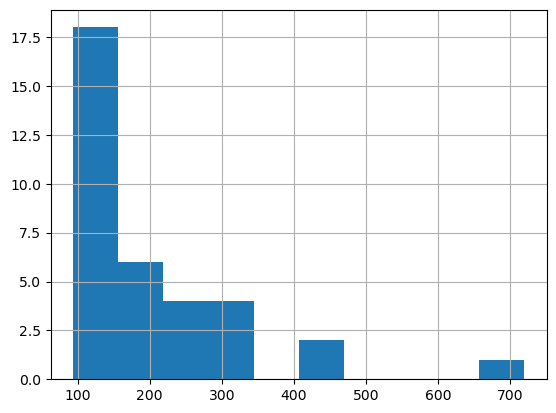

In [46]:
df['mol_weight'].hist()
plt.show()

In [47]:
chembl_df = chembl_df.map(
    lambda batch: process_batch(batch, mol_weight),
    num_proc=12,
    batched=True
)

chembl_df = chembl_df.map(
    lambda example: {"mol_weight_ok": example["mol_weight"] <= 1000}
)

counts = Counter(chembl_df["mol_weight_ok"])
print(counts)

Map (num_proc=12):   0%|          | 0/2474574 [00:00<?, ? examples/s]

[15:06:21] WARNING: not removing hydrogen atom without neighbors
[15:06:52] WARNING: not removing hydrogen atom without neighbors
[15:06:55] WARNING: not removing hydrogen atom without neighbors
[15:06:55] WARNING: not removing hydrogen atom without neighbors
[15:06:55] WARNING: not removing hydrogen atom without neighbors
[15:07:26] WARNING: not removing hydrogen atom without neighbors
[15:07:45] WARNING: not removing hydrogen atom without neighbors
[15:07:58] WARNING: not removing hydrogen atom without neighbors
[15:08:28] WARNING: not removing hydrogen atom without neighbors
[15:08:28] WARNING: not removing hydrogen atom without neighbors
[15:08:41] WARNING: not removing hydrogen atom without neighbors
[15:08:41] WARNING: not removing hydrogen atom without neighbors
[15:08:41] WARNING: not removing hydrogen atom without neighbors
[15:08:41] WARNING: not removing hydrogen atom without neighbors


Map:   0%|          | 0/2474574 [00:00<?, ? examples/s]

Counter({True: 2422624, False: 51950})


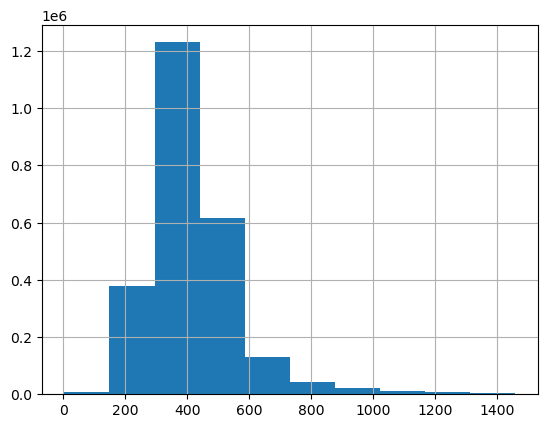

In [48]:
chembl_df_p = chembl_df.to_pandas()

chembl_df_f = chembl_df_p[chembl_df_p['mol_weight'] < chembl_df_p['mol_weight'].quantile(0.99)]
chembl_df_f['mol_weight'].hist()
plt.show()

#### 5. Молекулы могут содержать только следующие атомы: C, H, O, N, P, S

In [49]:
allowed_atoms = {'C', 'H', 'O', 'N', 'P', 'S'}

def only_allowed_atoms(smiles_str: str) -> bool:
    mol = Chem.MolFromSmiles(smiles_str)
    for atom in mol.GetAtoms():
        if atom.GetSymbol() not in allowed_atoms:
            return False
    return True

In [50]:
df['only_allowed_atoms'] = df['Smiles'].progress_apply(only_allowed_atoms)
df['only_allowed_atoms'].value_counts()

  0%|          | 0/35 [00:00<?, ?it/s]

only_allowed_atoms
True     32
False     3
Name: count, dtype: int64

In [51]:
df[~df['only_allowed_atoms']]

,Smiles,smiles_valid,is_aromatic_amine_or_phenol,neutral_and_no_radical,mol_weight,mol_weight_ok,only_allowed_atoms
15,C1=CC(=C(C=C1Cl)Cl)O,True,True,True,163.003,True,False
16,C1=C(C=C(C(=C1Cl)O)Cl)Cl,True,True,True,197.448,True,False
33,C1(=C(C(=C(C(=C1Cl)Cl)O)Cl)Cl)Cl,True,True,True,266.338,True,False


In [52]:
chembl_df = chembl_df.map(
    lambda batch: process_batch(batch, only_allowed_atoms),
    num_proc=12,
    batched=True
)


counts = Counter(chembl_df["only_allowed_atoms"])
print(counts)

Map (num_proc=12):   0%|          | 0/2474574 [00:00<?, ? examples/s]

[15:14:01] WARNING: not removing hydrogen atom without neighbors
[15:14:29] WARNING: not removing hydrogen atom without neighbors
[15:14:45] WARNING: not removing hydrogen atom without neighbors
[15:14:45] WARNING: not removing hydrogen atom without neighbors
[15:14:45] WARNING: not removing hydrogen atom without neighbors
[15:14:58] WARNING: not removing hydrogen atom without neighbors
[15:15:22] WARNING: not removing hydrogen atom without neighbors
[15:16:00] WARNING: not removing hydrogen atom without neighbors
[15:17:04] WARNING: not removing hydrogen atom without neighbors
[15:17:04] WARNING: not removing hydrogen atom without neighbors
[15:17:13] WARNING: not removing hydrogen atom without neighbors
[15:17:13] WARNING: not removing hydrogen atom without neighbors
[15:17:13] WARNING: not removing hydrogen atom without neighbors
[15:17:13] WARNING: not removing hydrogen atom without neighbors


Counter({True: 1502709, False: 971865})


#### 6. Молекулы растворимы в гексане (logP больше 1)

In [53]:
def log_p(smiles_str: str) -> float:
    mol = Chem.MolFromSmiles(smiles_str)
    logp = Descriptors.MolLogP(mol)
    return logp

In [56]:
df['log_p'] = df['Smiles'].progress_apply(log_p)
df['is_soluble_in_hexane'] = df['log_p'] > 1
df['is_soluble_in_hexane'].value_counts()

  0%|          | 0/35 [00:00<?, ?it/s]

is_soluble_in_hexane
True    35
Name: count, dtype: int64

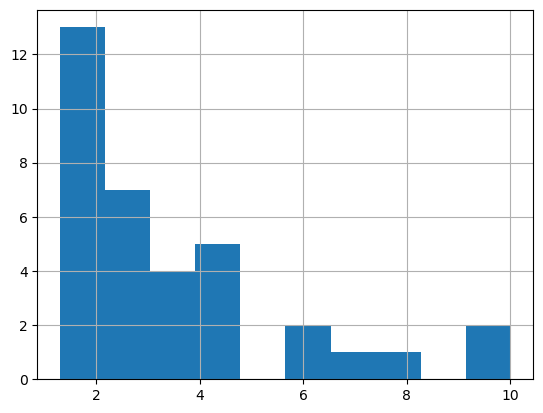

In [57]:
df['log_p'].hist()
plt.show()

In [60]:
chembl_df = chembl_df.map(
    lambda batch: process_batch(batch, log_p),
    num_proc=12,
    batched=True
)

chembl_df = chembl_df.map(
    lambda example: {"is_soluble_in_hexane": example["log_p"] > 1}
)

counts = Counter(chembl_df["is_soluble_in_hexane"])
print(counts)

Map (num_proc=12):   0%|          | 0/2474574 [00:00<?, ? examples/s]

[15:27:47] WARNING: not removing hydrogen atom without neighbors
[15:28:48] WARNING: not removing hydrogen atom without neighbors
[15:28:48] WARNING: not removing hydrogen atom without neighbors
[15:28:48] WARNING: not removing hydrogen atom without neighbors
[15:28:48] WARNING: not removing hydrogen atom without neighbors
[15:29:42] WARNING: not removing hydrogen atom without neighbors
[15:30:24] WARNING: not removing hydrogen atom without neighbors
[15:31:33] WARNING: not removing hydrogen atom without neighbors
[15:33:13] WARNING: not removing hydrogen atom without neighbors
[15:33:13] WARNING: not removing hydrogen atom without neighbors
[15:33:26] WARNING: not removing hydrogen atom without neighbors
[15:33:26] WARNING: not removing hydrogen atom without neighbors
[15:33:26] WARNING: not removing hydrogen atom without neighbors
[15:33:26] WARNING: not removing hydrogen atom without neighbors


Map:   0%|          | 0/2474574 [00:00<?, ? examples/s]

Counter({True: 2241504, False: 233070})


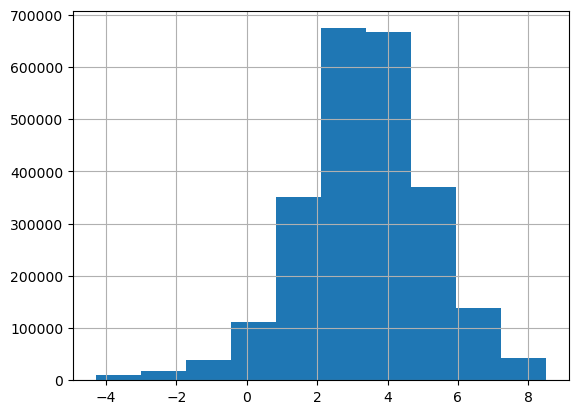

In [67]:
chembl_df_p = chembl_df.to_pandas()
chembl_df_f = chembl_df_p[(chembl_df_p['log_p'] < chembl_df_p['log_p'].quantile(0.99)) & (chembl_df_p['log_p'] > chembl_df_p['log_p'].quantile(0.01))]
chembl_df_f['log_p'].hist()
plt.show()

#### 7. Возможность синтеза (ретросинтетический анализ) и стабильность

In [62]:
def sa_score(smiles_str) -> float:
    mol = Chem.MolFromSmiles(smiles_str)
    return sascorer.calculateScore(mol)

In [63]:
chembl_df = chembl_df.map(
    lambda batch: process_batch(batch, sa_score),
    num_proc=12,
    batched=True
)

Map (num_proc=12):   0%|          | 0/2474574 [00:00<?, ? examples/s]

[15:41:00] WARNING: not removing hydrogen atom without neighbors
[15:41:51] WARNING: not removing hydrogen atom without neighbors
[15:42:10] WARNING: not removing hydrogen atom without neighbors
[15:42:10] WARNING: not removing hydrogen atom without neighbors
[15:42:10] WARNING: not removing hydrogen atom without neighbors
[15:42:39] WARNING: not removing hydrogen atom without neighbors
[15:43:23] WARNING: not removing hydrogen atom without neighbors
[15:44:12] WARNING: not removing hydrogen atom without neighbors
[15:45:49] WARNING: not removing hydrogen atom without neighbors
[15:45:49] WARNING: not removing hydrogen atom without neighbors
[15:46:05] WARNING: not removing hydrogen atom without neighbors
[15:46:05] WARNING: not removing hydrogen atom without neighbors
[15:46:05] WARNING: not removing hydrogen atom without neighbors
[15:46:05] WARNING: not removing hydrogen atom without neighbors


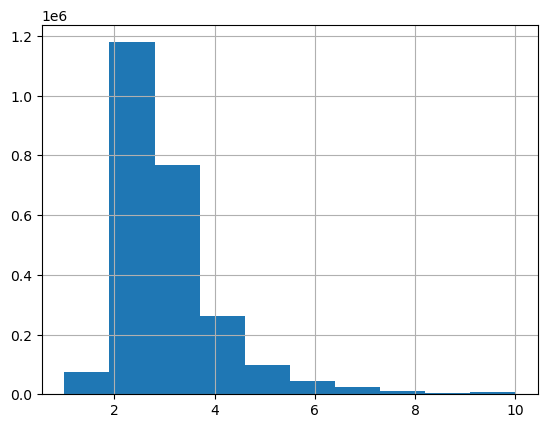

In [64]:
chembl_df_p = chembl_df.to_pandas()

chembl_df_p['sa_score'].hist()
plt.show()

In [68]:
chembl_df = chembl_df.map(
    lambda example: {"all_rools_valid": example["is_aromatic_amine_or_phenol"] and\
                      example["is_aromatic_amine_or_phenol"] and
                      example['neutral_and_no_radical'] and
                      example['mol_weight_ok'] and
                      example['only_allowed_atoms'] and
                      example['is_soluble_in_hexane']}
)

Map:   0%|          | 0/2474574 [00:00<?, ? examples/s]

In [70]:
counts = Counter(chembl_df['all_rools_valid'])
print(counts)

Counter({False: 1854047, True: 620527})


In [72]:
chembl_df.save_to_disk('data/processed_chembl')

Saving the dataset (0/2 shards):   0%|          | 0/2474574 [00:00<?, ? examples/s]

In [76]:
chembl_df.select(range(1000)).filter(lambda example: example["all_rools_valid"]).to_pandas()

,chembl_id,Smiles,standard_inchi,standard_inchi_key,smiles_valid,is_aromatic_amine_or_phenol,neutral_and_no_radical,mol_weight,mol_weight_ok,only_allowed_atoms,log_p,is_soluble_in_hexane,sa_score,all_rools_valid
0,CHEMBL153534,Cc1cc(-c2csc(N=C(N)N)n2)cn1C,InChI=1S/C10H13N5S/c1-6-3-7(4-15(6)2)8-5-16-10...,MFRNFCWYPYSFQQ-UHFFFAOYSA-N,True,True,True,235.316,True,True,1.36192,True,3.048474,True
1,CHEMBL503634,COc1c(O)cc(O)c(C(=N)Cc2ccc(O)cc2)c1O,InChI=1S/C15H15NO5/c1-21-15-12(19)7-11(18)13(1...,OPELSESCRGGKAM-UHFFFAOYSA-N,True,True,True,289.287,True,True,2.12817,True,2.658629,True
2,CHEMBL504077,COc1ccc2c(c1OC)C(CC1(C)C=Cc3c(c4cccc(OC)c4n(C)...,InChI=1S/C37H34N2O7/c1-37(15-14-24-34(46-37)23...,NUVWARFQHKLGOS-UHFFFAOYSA-N,True,True,True,618.686,True,True,6.85870,True,4.227592,True
3,CHEMBL501671,COc1cccc(CNC2(CCC(C)(C)C)C(=O)C(C3=NS(=O)(=O)c...,"InChI=1S/C32H36N4O7S2/c1-31(2,3)15-16-32(33-19...",BWBRRJGLAOHIOF-UHFFFAOYSA-N,True,True,True,652.795,True,True,4.94280,True,3.837715,True
4,CHEMBL403325,C[C@H]1CN(CCC(=O)N[C@@H](CCc2ccccc2)C(=O)O)CC[...,"InChI=1S/C26H34N2O4/c1-19-18-28(16-14-26(19,2)...",YJYUIXQWAGWQFA-FPDDQMOCSA-N,True,True,True,438.568,True,True,3.58400,True,3.288909,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,CHEMBL500782,CC(=O)O.O=S(=O)(NC1CCCCC1)c1cccc(CCCCOCCCCCCNC...,InChI=1S/C31H48N2O6S.C2H4O2/c34-24-27-22-26(16...,BKRQPAVUGJZATC-YNMZEGNTSA-N,True,True,True,636.852,True,True,4.80930,True,3.251199,True
126,CHEMBL503459,CN1CCC(NC(=O)c2cccc3c(NCCCCCCCCNc4c5ccccc5nc5c...,InChI=1S/C48H58N8O2/c1-55-29-23-33(24-30-55)51...,OYZSNKXSJPRNST-UHFFFAOYSA-N,True,True,True,779.046,True,True,8.60200,True,3.164803,True
127,CHEMBL503466,CC[C@H](C)[C@@H]([C@@H](CC(=O)N1CCC[C@H]1[C@H]...,InChI=1S/C48H73N5O10/c1-15-30(6)43(52(10)48(57...,ZWMFYTUAWZCSKI-LLJAODTESA-N,True,True,True,880.137,True,True,6.18870,True,5.240196,True
128,CHEMBL503046,CN1CC[C@]2(c3cccc4c3C[C@H]3N(C)CC[C@@]45[C@@H]...,InChI=1S/C45H51N7/c1-49-25-22-45-30-14-9-13-29...,JCVNBMQABOOGJB-CYWVKMGSSA-N,True,True,True,689.952,True,True,5.95610,True,6.538407,True
